## GNNStack notes
**CS224W stanford**  
**https://colab.research.google.com/drive/1DIQm9rOx2mT1bZETEeVUThxcrP1RKqAn#scrollTo=XyzIhe0O5ije**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
from torchviz import make_dot
from torch.autograd import Variable
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.datasets import CitationFull
from tqdm import tqdm
import pdb

#### Data analysis

In [2]:
data_cora = CitationFull('./CitationFull','cora')
data_cora_ml = CitationFull('./CitationFull','cora_ml')
data_citeseer =  CitationFull('./CitationFull','citeseer')
data_dblp =  CitationFull('./CitationFull','dblp')
data_pubmed =  CitationFull('./CitationFull','pubmed')
#data_raw = read_npz('./CitationFull/cora/raw/cora.npz')
#print(data_raw) # numer of edge_index: 126842 
#print(data.num_node_features) # Returns the number of features per node in the graph.
#print(data.num_classes) # Returns the number of classes.

dataset | num of edges | num of nodes | size of node features | num of num_classes
- | :-: | :-: | :-: | -:
cora | 126842 | 19793 | 8710 | 70| 
cora_ml | 16316| 2995 | 2879 | 7| 
citeseer | 10674|4230 | 602 | 6|
dblp | 105734| 17716| 1639| 4|
pubmed | 88648| 19717| 500| 3|

In [3]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)    # symmetric normalized Laplacian
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [4]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)
    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(150):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            #print(embedding.shape)     # why not batch size？？？？？？？？？？？？？？？？？？？ not 64
            label = batch.y
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

In [5]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        #if model.task == 'node':
            #mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            #pred = pred[mask]
            #label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            #print(len(data.y))
            #total += torch.sum(data.test_mask).item()
            total += len(data.y)
    #print(total)
    return correct / total

In [190]:
all_dataset =[data_cora,data_cora_ml,data_citeseer,data_dblp,data_pubmed]
all_dataset_name = ['cora','cora_ml','citeseer','dblp','pubmed']

In [197]:
for i,j in tqdm(zip(all_dataset,all_dataset_name)):
    writer = SummaryWriter("./log_"+j+'/' + datetime.now().strftime("%Y%m%d-%H%M%S"))
    dataset = i.shuffle()
    task = 'node'
    model = train(dataset, task, writer)

0it [00:00, ?it/s]

Epoch 0. Loss: 4.2978. Test accuracy: 0.0425
Epoch 10. Loss: 3.2422. Test accuracy: 0.2871
Epoch 20. Loss: 2.3083. Test accuracy: 0.5702
Epoch 30. Loss: 1.8494. Test accuracy: 0.6709
Epoch 40. Loss: 1.5955. Test accuracy: 0.7316
Epoch 50. Loss: 1.4260. Test accuracy: 0.7655
Epoch 60. Loss: 1.3177. Test accuracy: 0.7837
Epoch 70. Loss: 1.2298. Test accuracy: 0.8043
Epoch 80. Loss: 1.1664. Test accuracy: 0.8149
Epoch 90. Loss: 1.1224. Test accuracy: 0.8220
Epoch 100. Loss: 1.0808. Test accuracy: 0.8297
Epoch 110. Loss: 1.0557. Test accuracy: 0.8344
Epoch 120. Loss: 1.0090. Test accuracy: 0.8396
Epoch 130. Loss: 0.9907. Test accuracy: 0.8440
Epoch 140. Loss: 0.9641. Test accuracy: 0.8480


1it [03:50, 230.63s/it]

Epoch 0. Loss: 1.9674. Test accuracy: 0.2928
Epoch 10. Loss: 0.6544. Test accuracy: 0.8965
Epoch 20. Loss: 0.3723. Test accuracy: 0.9312
Epoch 30. Loss: 0.2876. Test accuracy: 0.9392
Epoch 40. Loss: 0.2422. Test accuracy: 0.9476
Epoch 50. Loss: 0.1932. Test accuracy: 0.9543
Epoch 60. Loss: 0.1827. Test accuracy: 0.9636
Epoch 70. Loss: 0.1684. Test accuracy: 0.9646
Epoch 80. Loss: 0.1626. Test accuracy: 0.9656
Epoch 90. Loss: 0.1509. Test accuracy: 0.9710
Epoch 100. Loss: 0.1338. Test accuracy: 0.9703
Epoch 110. Loss: 0.1247. Test accuracy: 0.9756
Epoch 120. Loss: 0.1437. Test accuracy: 0.9740
Epoch 130. Loss: 0.1214. Test accuracy: 0.9780
Epoch 140. Loss: 0.1110. Test accuracy: 0.9790


2it [04:06, 166.31s/it]

Epoch 0. Loss: 1.8187. Test accuracy: 0.5173
Epoch 10. Loss: 0.3267. Test accuracy: 0.9608
Epoch 20. Loss: 0.1524. Test accuracy: 0.9818
Epoch 30. Loss: 0.1090. Test accuracy: 0.9853
Epoch 40. Loss: 0.0729. Test accuracy: 0.9851
Epoch 50. Loss: 0.0581. Test accuracy: 0.9884
Epoch 60. Loss: 0.0612. Test accuracy: 0.9917
Epoch 70. Loss: 0.0525. Test accuracy: 0.9929
Epoch 80. Loss: 0.0502. Test accuracy: 0.9920
Epoch 90. Loss: 0.0490. Test accuracy: 0.9924
Epoch 100. Loss: 0.0419. Test accuracy: 0.9943
Epoch 110. Loss: 0.0324. Test accuracy: 0.9943
Epoch 120. Loss: 0.0373. Test accuracy: 0.9943
Epoch 130. Loss: 0.0483. Test accuracy: 0.9953
Epoch 140. Loss: 0.0317. Test accuracy: 0.9960


3it [04:15, 118.97s/it]

Epoch 0. Loss: 1.4054. Test accuracy: 0.4507
Epoch 10. Loss: 0.4759. Test accuracy: 0.8586
Epoch 20. Loss: 0.3766. Test accuracy: 0.8810
Epoch 30. Loss: 0.3235. Test accuracy: 0.8908
Epoch 40. Loss: 0.2899. Test accuracy: 0.9023
Epoch 50. Loss: 0.2599. Test accuracy: 0.9103
Epoch 60. Loss: 0.2352. Test accuracy: 0.9174
Epoch 70. Loss: 0.2209. Test accuracy: 0.9240
Epoch 80. Loss: 0.2023. Test accuracy: 0.9274
Epoch 90. Loss: 0.1959. Test accuracy: 0.9322
Epoch 100. Loss: 0.1778. Test accuracy: 0.9366
Epoch 110. Loss: 0.1711. Test accuracy: 0.9358
Epoch 120. Loss: 0.1675. Test accuracy: 0.9410
Epoch 130. Loss: 0.1574. Test accuracy: 0.9434
Epoch 140. Loss: 0.1537. Test accuracy: 0.9434


4it [05:37, 107.90s/it]

Epoch 0. Loss: 1.1047. Test accuracy: 0.4112
Epoch 10. Loss: 0.5438. Test accuracy: 0.8352
Epoch 20. Loss: 0.4184. Test accuracy: 0.8695
Epoch 30. Loss: 0.3630. Test accuracy: 0.8856
Epoch 40. Loss: 0.3356. Test accuracy: 0.8946
Epoch 50. Loss: 0.3030. Test accuracy: 0.9005
Epoch 60. Loss: 0.2886. Test accuracy: 0.9064
Epoch 70. Loss: 0.2640. Test accuracy: 0.9137
Epoch 80. Loss: 0.2495. Test accuracy: 0.9179
Epoch 90. Loss: 0.2404. Test accuracy: 0.9210
Epoch 100. Loss: 0.2294. Test accuracy: 0.9261
Epoch 110. Loss: 0.2192. Test accuracy: 0.9299
Epoch 120. Loss: 0.2184. Test accuracy: 0.9300
Epoch 130. Loss: 0.2165. Test accuracy: 0.9321
Epoch 140. Loss: 0.2097. Test accuracy: 0.9328


5it [06:38, 79.70s/it] 


In [157]:
# plot model structure
loader = DataLoader(dataset, batch_size=64, shuffle=True)
plot_model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
for batch in loader:
    y = plot_model(batch)
    g = make_dot(y, params=dict(plot_model.named_parameters()))
    g.view()
    break

### embedding visualization

Epoch 0. Loss: 1.3814. Test accuracy: 0.6472
Epoch 10. Loss: 0.4662. Test accuracy: 0.8359
Epoch 20. Loss: 0.3818. Test accuracy: 0.8775
Epoch 30. Loss: 0.3236. Test accuracy: 0.8897
Epoch 40. Loss: 0.2923. Test accuracy: 0.8999
Epoch 50. Loss: 0.2585. Test accuracy: 0.9090
Epoch 60. Loss: 0.2379. Test accuracy: 0.9193
Epoch 70. Loss: 0.2159. Test accuracy: 0.9264
Epoch 80. Loss: 0.2005. Test accuracy: 0.9294
Epoch 90. Loss: 0.1943. Test accuracy: 0.9347
Epoch 100. Loss: 0.1886. Test accuracy: 0.9394
Epoch 110. Loss: 0.1732. Test accuracy: 0.9402
Epoch 120. Loss: 0.1652. Test accuracy: 0.9437
Epoch 130. Loss: 0.1632. Test accuracy: 0.9454
Epoch 140. Loss: 0.1597. Test accuracy: 0.9455


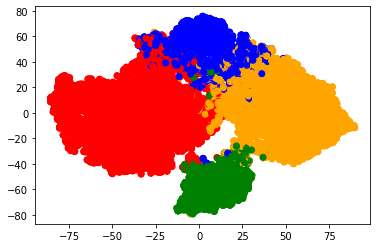

In [12]:
# dataset: dblp
writer = SummaryWriter("./log"+ datetime.now().strftime("%Y%m%d-%H%M%S"))
model = train(data_dblp, 'node', writer)
color_list = ["red", "orange", "green", "blue", "purple", "brown","black"]
loader = DataLoader(data_dblp, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)